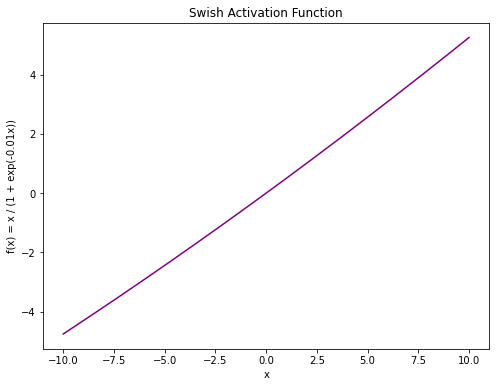

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Swish activation function
def swish(x, beta):
    return x / (1 + np.exp(-1 * beta * x))

# Generate data points
beta = 0.01
x = np.linspace(-10, 10, 400)
y = swish(x, beta)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Swish Activation Function", color='purple')
plt.title("Swish Activation Function")
plt.xlabel("x")
plt.ylabel(f"f(x) = x / (1 + exp(-{beta}x))")
#plt.grid(True)
#plt.legend()
plt.savefig("swish.png",transparent =True)
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


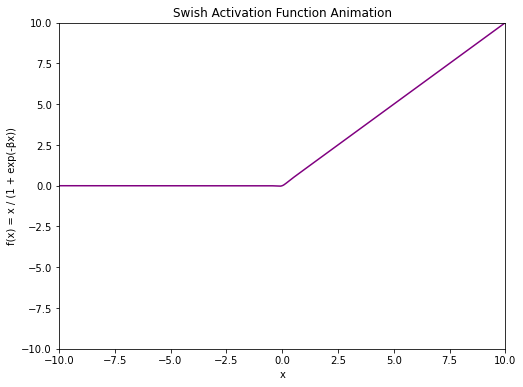

In [17]:

from matplotlib.animation import FuncAnimation

# Define parameters
betas = np.linspace(0, 10, 100)
x = np.linspace(-10, 10, 400)


# Correcting the function definition to accept the beta parameter
def swish(x, beta):
    return x / (1 + np.exp(-1 * beta * x))

# Create a figure and axis again
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the plot line
line, = ax.plot([], [], color='purple')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
#ax.grid(True)

# Title and labels
ax.set_title("Swish Activation Function Animation")
ax.set_xlabel("x")
ax.set_ylabel("f(x) = x / (1 + exp(-βx))")

# Update function for animation
def update(beta):
    y = swish(x, beta)
    line.set_data(x, y)
    #ax.set_ylabel(f"f(x) = x / (1 + exp(-{beta}x))")
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=betas, repeat=True)

# Save animation
ani.save('swish_animation_corrected.gif', writer='imagemagick', fps=2,savefig_kwargs={'transparent': True, 'facecolor': 'none'})


In [22]:
'''
todo:
0、跑通Q强化学习的程序 (2024-04-29)：已完成
1、完成StockTradingEnv类的编写 (2024-04-29)：已完成
2、check StockTradingEnv的逻辑 (2024-04-30)：已完成
2、完成State的编写 (2024-04-30)：已完成
3、优化代码和参数 (2024-05-01)：已完成
4、Early Stopping (2024-05-13)：已完成
5、加上交叉验证功能 (2024-05-13)：已完成
6、加上贝叶斯算法调整超参数 (2024-05-13)：已完成
7、加入DQN正则化项 (2024-05-13)：已完成
8、移除Softmax层 (2024-05-14)：已完成
9、window_size > 1调整 (2024-05-14)：已完成
8、加入LSTM和Attention等时序架构 (2024-05-15)
9、加入CPD等时序架构 (2024-05-15)
10、开发样本内表现分析架构 (2024-05-15)
11、加入其他技术因子 (2024-05-16)
12、训练预测周期数据 (2024-05-17)
'''


import multiprocessing
import random
import warnings
from collections import deque

import numpy as np
import torch
import torch.nn as nn
from jqdatasdk import *
from sklearn.model_selection import TimeSeriesSplit
from skopt import gp_minimize
from skopt.callbacks import DeadlineStopper
from skopt.space import Real, Integer
from skopt.utils import use_named_args

auth("18917616684", "Baihua2023")
warnings.filterwarnings("ignore")
random.seed(5)
np.random.seed(5)
torch.manual_seed(5)  # 0
torch.set_num_threads(multiprocessing.cpu_count())


ticker_var = "000300.XSHG"
transaction_costs_var = 0.0005
ts_splits_lg_var = False
ts_splits_var = 2
long_only_index_var = True

early_stopping_rounds_var = 50  # 30
bayes_rounds_var = 15
bayes_verbose_var = False
count_index_var = 1
bayes_freq_var = 100000

num_episodes_var = 1000  # 训练的总轮数, 1000
initial_capital_var = 10000000
windows_size_var = 2  # windows_size >= 2
random_num_bayes_var = 5  # 42
blocks_training_var = 250  # 50
blocks_prediction_var = 5
target_update_freq_var = 1  # 目标网络更新频率, 10
eps_var = 0.1  # ε-greedy策略中的ε初始值
eps_decay_var = 0.95  # ε的衰减率, 0.95

results_var = [1e-4, 0.95, 0.05, 32, 1.00, 128, 128]
trading_days_var = get_trade_days(
    start_date="2020-01-01", end_date="2024-05-10"
)


# DQN网络定义, 完成
class DQN(nn.Module):
    def __init__(self, state_size, out_f_1, out_f_2, action_size=2):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, out_f_1)
        self.fc2 = nn.Linear(out_f_1, out_f_2)
        self.fc3 = nn.Linear(out_f_2, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 股票交易类，完成
class StockTradingEnv:
    def __init__(
            self,
            df,
            long_only,
            initial_balance=initial_capital_var,
            window_size=windows_size_var,
            transaction_costs=transaction_costs_var
    ):
        """
        Initialize the StockTradingEnv environment.

        :param df: DataFrame containing historical stock prices.
                   Columns should include 'close', 'High', 'Low', 'close' and 'Volume'.
        :param initial_balance: Initial cash balance.
        :param window_size: Number of days of historical prices to use as state.
        :param transaction_costs: Percentage transaction costs (e.g., 0.001 for 0.1%).
        """
        self.df = df
        self.ls = long_only
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares_held = 0
        self.transaction_costs = transaction_costs
        self.current_step = 0
        self.state_space = self.df.shape[0] - window_size + 1
        self.observation_space = self.df.shape[1]
        self.action_space = [0, 1]  # Buy, Sell, Hold
        self.indicator = 0
        self.portfolio_value = 0

    def reset(self, windows_block=windows_size_var):
        """
        Reset the environment to its initial state.
        """
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = windows_block
        self.window_size = windows_block
        self.indicator = 0
        state = self.get_state()
        return state

    def step(self, action):
        """
        Take an action in the environment.

        :param action: An integer representing the action to take (0: Buy, 1: Sell, 2: Hold).
        :return: Next state, reward, done, and info.
        """
        if self.current_step >= self.state_space-1:
            done = True
        else:
            done = False

        # Calculate the reward based on the action taken
        if action == 0 and self.indicator == 0:  # Buy
            shares_to_buy = int(self.balance / self.df['close'].iloc[self.current_step])
            cost = shares_to_buy * self.df['close'].iloc[self.current_step] * (1 + self.transaction_costs)
            self.balance -= cost
            self.shares_held = shares_to_buy
            self.indicator = 1
        elif action == 1 and self.indicator == 1:  # Sell
            proceeds = self.shares_held * self.df['close'].iloc[self.current_step] * (1 - self.transaction_costs)
            self.balance += proceeds
            self.shares_held = 0
            self.indicator = 0

        if not self.ls:
            if action == 1 and self.indicator == 0:
                shares_to_sell = int(self.balance / self.df['close'].iloc[self.current_step])
                proceeds = shares_to_sell * self.df['close'].iloc[self.current_step] * (1 + self.transaction_costs)
                self.balance += proceeds
                self.shares_held = -shares_to_sell
                self.indicator = -1
            elif action == 0 and self.indicator == -1:
                shares_to_buy = -self.shares_held
                cost = shares_to_buy * self.df['close'].iloc[self.current_step] * (1 - self.transaction_costs)
                self.balance -= cost
                self.shares_held = 0
                self.indicator = 0

        # Calculate portfolio value as the reward
        self.portfolio_value = self.balance + (self.shares_held * self.df['close'].iloc[self.current_step])

        # Define Reward Function
        reward = self.portfolio_value - self.initial_balance

        # Move to the next state
        self.current_step += 1
        next_state = self.get_state()

        return next_state, reward, done, {}

    def get_state(self):
        """
        Get the current state of the environment.
        """
        beginning = self.current_step-self.window_size
        state = self.df.iloc[beginning:self.current_step, :].values
        return state

    def render(self):
        """
        Render the environment (not implemented in this simple example).
        """
        pass

    def close(self):
        """
        close the environment (not implemented in this simple example).
        """
        pass


# 内存buffer，完成
class ReplayBuffer_origin:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.length = 0

    def push(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        self.buffer.append((state, action, reward, next_state, done))
        self.length += 1

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (torch.stack(state, dim=0), torch.tensor(action),
                torch.tensor(reward, dtype=torch.float32), torch.stack(next_state), torch.tensor(done))

    def __len__(self):
        return len(self.buffer)


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
        self.length = 0

    def push(self, state, action, reward, next_state, done):
        state = torch.tensor(state.astype(np.float32), dtype=torch.float32)
        next_state = torch.tensor(next_state.astype(np.float32), dtype=torch.float32)
        self.buffer.append((state, action, reward, next_state, done))
        self.length += 1

    def add(self, state, action, reward, next_state, done):
        if self.length >= self.capacity:
            self.buffer.pop()
        self.buffer.append((state, action, reward, next_state, done))
        self.length += 1

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (torch.stack(state), torch.tensor(action),
                torch.tensor(reward, dtype=torch.float32), torch.stack(next_state), torch.tensor(done))


# 选择行动，完成
def select_action(state, dqn, eps=0.05):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, 2)  # 随机选择动作
    else:
        with torch.no_grad():
            q_values = dqn(torch.tensor(state, dtype=torch.float32))
        return q_values.argmax(axis=1)[0]  # 选择Q值最高的动作


# 训练函数，完成
def train(gamma, dqn, criterion, optimizer, target_dqn, replay_buffer, batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    actions_reshape = action
    temp_q = dqn(state)
    q_values = temp_q.gather(
        2,
        actions_reshape.unsqueeze(1).unsqueeze(2).repeat([1, temp_q.shape[1], temp_q.shape[2]])
    )[:, :, 0]
    with torch.no_grad():
        next_q_values = torch.tensor(
            torch.max(target_dqn(next_state), dim=2)[0],
            requires_grad=True
        )
        expected_q_values = torch.tensor(
            reward.unsqueeze(1).repeat([1, next_q_values.shape[1]]) \
            + (1 - torch.tensor(done, dtype=torch.int16))[-1] * gamma * next_q_values,  # 计算目标Q值
            requires_grad=True
        )
    loss = torch.tensor(
        criterion(
            q_values.detach(),
            expected_q_values.detach()
            ),  # 计算损失
        requires_grad=True
    )
    optimizer.zero_grad()  # 清空梯度
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重


def reinforcement_learning_training_engine(
        x,
        num_episodes,
        target_update_freq,
        eps,
        eps_decay,
        params
):
    max_reward = -np.inf
    env = StockTradingEnv(x, long_only_index_var)
    max_steps = int(x.shape[0])-1

    # DQN训练过程
    input_dim = env.observation_space  # 状态空间的维度
    output_dim = len(env.action_space)  # 动作空间的大小（离散动作数量）

    dqn = DQN(input_dim, params[5], params[6], output_dim)
    target_dqn = DQN(input_dim, params[5], params[6], output_dim)
    target_dqn.load_state_dict(dqn.state_dict())  # 初始时复制DQN的权重给目标DQN)

    replay_buffer = ReplayBuffer_origin(capacity=10000000)  # 设置缓冲区容量

    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(dqn.parameters(), lr=params[0], weight_decay=params[4])  # 0.05, 0.10

    early_stopping_list = []
    counts = 0
    max_dqn = None
    for episode in range(num_episodes):
        state = env.reset(windows_size_var)
        total_reward = 0
        action_list = []
        pv = []
        if episode % target_update_freq == 0:
            target_dqn.load_state_dict(dqn.state_dict())  # 更新目标网络权重
        for step in range(max_steps):
            state_torch_tensor = torch.tensor(state, dtype=torch.float32)
            action = select_action(state_torch_tensor, dqn, eps)
            next_state, reward, done, _ = env.step(action)
            next_state_torch_tensor = torch.tensor(next_state, dtype=torch.float32)
            replay_buffer.push(state_torch_tensor, action, reward, next_state_torch_tensor, done)
            state = next_state
            total_reward = reward
            if replay_buffer.length > params[3]+1:
                train(params[1], dqn, criterion, optimizer, target_dqn, replay_buffer, params[3])
                action_list.append(action)
                pv.append(env.portfolio_value)
            if done:
                break
        eps = max(eps * eps_decay, params[2])  # 更新ε值
        if max_reward <= total_reward:
            max_dqn = dqn
            max_reward = total_reward
        early_stopping_list.append(max_reward)
        if (len(early_stopping_list) >= 2) and (early_stopping_list[-1] == early_stopping_list[-2]):
            counts += 1
        elif (len(early_stopping_list) >= 2) and (early_stopping_list[-1] != early_stopping_list[-2]):
            counts = 0
        if counts >= early_stopping_rounds_var:
            break
    return max_dqn


def reinforcement_learning_training_prediction_engine(
        x,
        dqn_model,
        eps
):
    env = StockTradingEnv(x, long_only_index_var)
    portfolios = [env.initial_balance]
    max_steps = int(blocks_prediction_var)
    state = env.reset(1)
    action_list = []
    pv = []
    for step in range(max_steps):
        action = select_action(state, dqn_model, eps)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        action_list.append(action)
        pv.append(portfolios[-1] + env.portfolio_value - env.initial_balance)
        if done:
            break
    portfolios.extend(pv)
    return portfolios[-1]-portfolios[0]


def reinforcement_learning_testing_prediction_engine(
        x,
        dqn_model,
        eps
):
    env = StockTradingEnv(x, long_only_index_var)
    portfolios = [env.initial_balance]
    max_steps = int(blocks_prediction_var)
    state = env.reset(1)
    action_list = []
    pv = []
    for step in range(max_steps):
        action = select_action(state, dqn_model, eps)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        action_list.append(action)
        pv.append(portfolios[-1] + env.portfolio_value - env.initial_balance)
        if done:
            break
    portfolios.extend(pv)
    return portfolios[-1]-portfolios[0], action_list


def in_sample_traing_bayes(datum, splits_logic=False):
    tscv = TimeSeriesSplit(n_splits=ts_splits_var)
    x = datum
    @use_named_args(
        dimensions=[
            Real(low=0.001, high=0.50, name='learning_rate'),
            Real(low=0.25, high=1, name='gamma'),
            Real(low=0.001, high=0.10, name='eps_min'),
            Integer(low=16, high=128, name='batch_size'),
            Real(low=0.01, high=5, name='weight_decay'),
            Integer(low=4, high=256, name='out_fn_1'),
            Integer(low=4, high=256, name='out_fn_2')
        ]
    )

    def objective(**params):
        val_scores = []
        if splits_logic:
            for train_index, val_index in tscv.split(x):
                X_train, X_val = x.iloc[train_index, :], x.iloc[val_index]
                model = reinforcement_learning_training_engine(
                        X_train,
                        num_episodes_var,
                        target_update_freq_var,
                        eps_var,
                        eps_decay_var,
                        [
                            params['learning_rate'],
                            params['gamma'],
                            params['eps_min'],
                            params['batch_size'],
                            params['weight_decay'],
                            params['out_fn_1'],
                            params['out_fn_2']
                        ]
                    )
                val_rewards = reinforcement_learning_training_prediction_engine(
                        X_val,
                        model,
                        params['eps_min']
                    )
                val_scores.append(np.mean(val_rewards))
        else:
            model = reinforcement_learning_training_engine(
                datum,
                num_episodes_var,
                target_update_freq_var,
                eps_var,
                eps_decay_var,
                [
                    params['learning_rate'],
                    params['gamma'],
                    params['eps_min'],
                    params['batch_size'],
                    params['weight_decay'],
                    params['out_fn_1'],
                    params['out_fn_2']
                ]
            )

            val_rewards = reinforcement_learning_training_prediction_engine(
                datum,
                model,
                params['eps_min']
            )
            val_scores.append(val_rewards)

        return -np.mean(val_scores)

    # 进行贝叶斯优化
    result = gp_minimize(
        objective,
        dimensions=[
            Real(low=0.001, high=0.50, name='learning_rate'),
            Real(low=0.25, high=1, name='gamma'),
            Real(low=0.001, high=0.10, name='eps_min'),
            Integer(low=16, high=128, name='batch_size'),
            Real(low=0.01, high=5, name='weight_decay'),
            Integer(low=4, high=256, name='out_fn_1'),
            Integer(low=4, high=256, name='out_fn_2')
        ],
        n_random_starts=10,
        acq_func='EI',  # Expected Improvement
        n_calls=bayes_rounds_var,  # Number of iterations
        noise=0.005,  # Optional, noise level (optional)
        random_state=random_num_bayes_var,  # Random seed
        callback=[DeadlineStopper(1800)],  # Stop after 10 minutes
        verbose=bayes_verbose_var
    )
    return result.x


portfolios = [initial_capital_var]
for days_index in range(blocks_training_var, len(trading_days_var)-blocks_prediction_var, blocks_prediction_var):
    # In-Sample Training
    data = get_price(
        ticker_var,
        start_date=trading_days_var[days_index - blocks_training_var],
        end_date=trading_days_var[days_index],
        fields=["close"],
        fq="post"
    )
    data['time'] = data.index
    data = data.reset_index(drop=True).iloc[:, :-1]
    data['ex_close'] = data['close'].shift(1).fillna(method='bfill')

    if count_index_var % bayes_freq_var == 0:
        results = in_sample_traing_bayes(data, ts_splits_lg_var)
    count_index_var += 1

    dqn_opt = reinforcement_learning_training_engine(
        data,
        num_episodes_var,
        target_update_freq_var,
        eps_var,
        eps_decay_var,
        results_var
    )

    # Out-of-Sample Prediction
    data = get_price(
        ticker_var,
        start_date=trading_days_var[days_index-windows_size_var],
        end_date=trading_days_var[days_index+blocks_prediction_var],
        fields=["close"],
        fq="post"
    )
    data['time'] = data.index
    data = data.reset_index(drop=True).iloc[:, :-1]
    data['ex_close'] = data['close'].shift(1).fillna(method='bfill')

    pvs, actions = reinforcement_learning_testing_prediction_engine(
        data,
        dqn_opt,
        results_var[2],
    )

    portfolios.append(
        portfolios[-1] + pvs
    )

    print(trading_days_var[days_index+blocks_prediction_var])
    print("%4.2f" %portfolios[-1])
    print("%4.2f" %np.mean(actions))


ImportError: cannot import name 'gp_minimize' from 'skopt' (/Users/xrz/Desktop/Chaos/LLM Examples/FlamingoExample/skopt/skopt/__init__.py)

In [6]:
!pip install scikit-optimize